In [1]:
import pandas as pd
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
%matplotlib inline

In [2]:
tf.__version__

'2.0.1'

In [3]:
tf.test.is_gpu_available()

True

In [4]:
# gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
# tf.config.experimental.set_virtual_device_configuration( gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3700)])


In [5]:
myshape = (229,229,1)

### load data

In [6]:
def load_img(img,lab):
    img=tf.io.read_file(img)
    img=tf.image.decode_jpeg(img, channels=1)
    img = tf.cast(img,tf.float32) ##???
    lab = tf.cast(lab,tf.float32)/2 #####???    turn 0,2,4 to 0,1,2 otherwise loss=NaN
    return img,lab

In [7]:
test_data=pd.read_csv('test.txt',header=None,sep=' ',names=['picture','label'])
train_data=pd.read_csv('train.txt',header=None,sep=' ',names=['picture','label'])
valid_data=pd.read_csv('valid.txt',header=None,sep=' ',names=['picture','label'])
# test_data.head()

In [8]:
test_data['dir']=[os.path.join('preprocessed','test',pic) for pic in test_data['picture']]
train_data['dir']=[os.path.join('preprocessed','train',pic) for pic in train_data['picture']]
valid_data['dir']=[os.path.join('preprocessed','valid',pic) for pic in valid_data['picture']]
# test_data.head()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B4AE7F82C8>]],
      dtype=object)

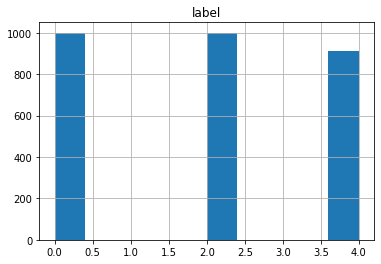

In [9]:
total_set = pd.concat([test_data,train_data,valid_data],ignore_index=True)
iid_total_set = pd.concat([total_set[total_set['label']==i*2][:1000] for i in range(3)])
iid_total_set.hist()

In [10]:
random_set = iid_total_set.sample(frac=1).reset_index(drop=True)

In [11]:
## settings
fraction_val = 0.2

valid_LEN=int(len(random_set)*fraction_val)
train_LEN=int(len(random_set)-valid_LEN)

batch_SIZE=100 ### should't be that small but my laptop....
train_EPO=int(train_LEN // batch_SIZE)
valid_EPO=int(valid_LEN // batch_SIZE)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B4D6145388>]],
      dtype=object)

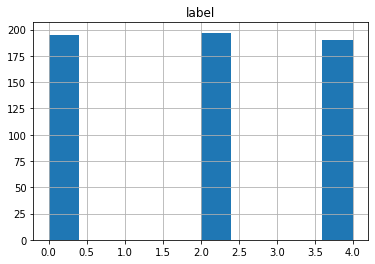

In [12]:
iid_valid = random_set[:valid_LEN]
iid_valid.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B4D824F0C8>]],
      dtype=object)

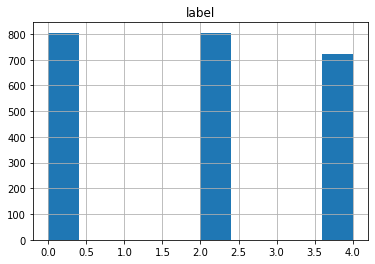

In [13]:
iid_train = random_set[valid_LEN:valid_LEN+train_LEN]
iid_train.hist()

In [14]:
train_SET = tf.data.Dataset.from_tensor_slices((iid_train['dir'],iid_train['label'])).\
                            shuffle(train_LEN).\
                            map(load_img).\
                            batch(batch_SIZE).\
                            repeat().\
                            prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_SET = tf.data.Dataset.from_tensor_slices((iid_valid['dir'],iid_valid['label'])).\
                            shuffle(valid_LEN).\
                            map(load_img).\
                            batch(batch_SIZE).\
                            repeat().\
                            prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
model = tf.keras.applications.xception.Xception(include_top=True, weights=None, input_shape=myshape, classes=6)
# it said include_top should be false if input_shape is not (229,229,3), but the only difference is to add avg_pooling and prediction

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 229, 229, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 114, 114, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 114, 114, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 114, 114, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 7, 7, 1024)   4096        conv2d_3[0][0]                   
__________________________________________________________________________________________________
add_11 (Add)                    (None, 7, 7, 1024)   0           block13_pool[0][0]               
                                                                 batch_normalization_3[0][0]      
__________________________________________________________________________________________________
block14_sepconv1 (SeparableConv (None, 7, 7, 1536)   1582080     add_11[0][0]                     
__________________________________________________________________________________________________
block14_sepconv1_bn (BatchNorma (None, 7, 7, 1536)   6144        block14_sepconv1[0][0]           
__________________________________________________________________________________________________
block14_se

In [ ]:
epo=10
history= model.fit(train_SET,
                  epochs=epo,
                  steps_per_epoch=train_EPO,
                  validation_data=valid_SET,
                  validation_steps=valid_EPO
                  )

In [ ]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

In [ ]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

In [ ]:
model.save_weights('myXception.h5')

acc = history.history.get('acc')
val_acc = history.history.get('val_acc')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')


np.save("acc.npy", acc)
np.save("val_acc.npy", val_acc)
np.save("loss.npy", loss)
np.save("val_loss.npy", val_loss)